In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

In [4]:
HIDDEN_UNITS = 256
INPUT_UNITS = 218

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(INPUT_UNITS, 2 * HIDDEN_UNITS)
        self.hidden_active1 = nn.ReLU()
        self.hidden2 = nn.Linear(2 * HIDDEN_UNITS, HIDDEN_UNITS)
        self.hidden_active2 = nn.ReLU()
        self.hidden3 = nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS)
        self.hidden_active3 = nn.ReLU()
        self.hidden4 = nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS)
        self.hidden_active4 = nn.ReLU()
        self.out = nn.Linear(HIDDEN_UNITS, 1)
        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden_active1(x)
        x = self.hidden2(x)
        x = self.hidden_active2(x)
        x = self.hidden3(x)
        x = self.hidden_active3(x)
        x = self.hidden4(x)
        x = self.hidden_active4(x)
        x = self.out(x)
        return x

In [6]:
model = Net()
summary(model, input_size=(1, 218))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 1]                    --
├─Linear: 1-1                            [1, 512]                  112,128
├─ReLU: 1-2                              [1, 512]                  --
├─Linear: 1-3                            [1, 256]                  131,328
├─ReLU: 1-4                              [1, 256]                  --
├─Linear: 1-5                            [1, 256]                  65,792
├─ReLU: 1-6                              [1, 256]                  --
├─Linear: 1-7                            [1, 256]                  65,792
├─ReLU: 1-8                              [1, 256]                  --
├─Linear: 1-9                            [1, 1]                    257
Total params: 375,297
Trainable params: 375,297
Non-trainable params: 0
Total mult-adds (M): 0.38
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.50
Estimated Total Size (MB)

In [7]:
X = pd.read_csv('X_10_no_bombs.csv')
y = pd.read_csv('y_10_no_bombs.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print(X.shape)
X.dropna(inplace=True)
print(X.shape)

(35405, 218)
(35405, 218)


In [9]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [11]:
X_train.shape

torch.Size([28324, 218])

In [12]:
BATCH_SIZE = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
loss_list = []
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_list.append(running_loss / len(train_loader))

In [13]:
model = Net()
for i in tqdm(range(100)):   
    train(model, train_loader, optim.Adam(model.parameters(), lr=0.01), model.loss)

100%|██████████| 100/100 [06:29<00:00,  3.90s/it]


In [14]:
loss_list

[32763.52012582611,
 4967.942342719429,
 4282.342727626688,
 3980.1505649127485,
 3855.4424859040478,
 3864.1625956929297,
 3694.7776989387876,
 3735.50496551307,
 3652.7888602263233,
 3588.940027241244,
 3595.008058121726,
 3648.3100528071213,
 3611.55158400697,
 3498.7889569973568,
 3444.3016717019523,
 3424.678699433131,
 3466.0041391962536,
 3464.5007754082603,
 3502.122884952726,
 3437.502927000851,
 3428.00319027524,
 3434.4550044832595,
 3443.4797881322306,
 3404.9830917806175,
 3370.0846438784633,
 3405.270209129454,
 3343.867432949505,
 3328.756739907017,
 3328.4268737861858,
 3332.5729433494553,
 3333.400716019538,
 3387.1434280705507,
 3400.8324279096273,
 3354.5137246779877,
 3361.6238146366436,
 3327.799034032542,
 3340.236179257085,
 3297.056706206793,
 3382.204741846089,
 3314.330628543621,
 3391.432008351483,
 3313.8773794411,
 3331.2381087189065,
 3339.235831714914,
 3345.546166792411,
 3328.912583361899,
 3298.857934990532,
 3333.3943745632473,
 3272.1014621467675,
 3

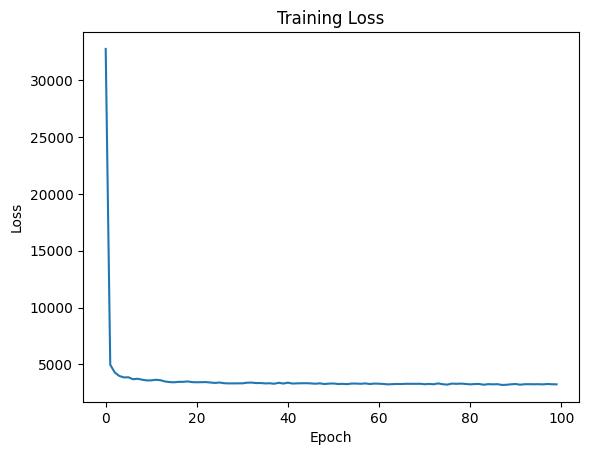

In [15]:
plt.plot(loss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
# test
model.eval()
predictions = []
for x in X_test:
    x = x.reshape(1, 218)
    x = torch.tensor(x, dtype=torch.float32)
    y_pred = model.forward(x)
    predictions.append(y_pred.item())

model.score = model.loss(torch.tensor(predictions, dtype=torch.float32), y_test.squeeze())
print(model.score.item())

C:\Users\charl\AppData\Local\Temp\ipykernel_82316\2067007474.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


3053.041015625


In [17]:
r = np.corrcoef(predictions, y_test.squeeze())
print(r[0][1] ** 2)

0.8919071361177762


In [20]:
# calculate R^2
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)
r2 = r_squared(np.array(y_test.squeeze().tolist()), np.array(predictions))
print(r2)

0.8917089031321114


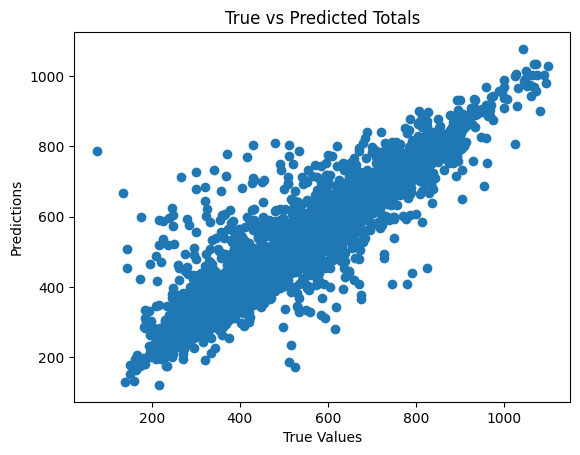

In [ ]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Totals')
plt.show()